In [2]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
from math import hypot
from time import time 
import pyautogui

In [3]:
mp_pose = mp.solutions.pose
pose_img = mp_pose.Pose(static_image_mode=True,min_detection_confidence=0.5,model_complexity=1)
pose_video = mp_pose.Pose(static_image_mode=False,min_detection_confidence=0.7,min_tracking_confidence=0.7,model_complexity=1)
mp_drawing = mp.solutions.drawing_utils

In [4]:
def detectPose(image,pose,draw=False,display=False):
    output_image = image.copy()
    imageRGB = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    results = pose.process(imageRGB)
    if results.pose_landmarks and draw:
        mp_drawing.draw_landmarks(image=output_image,landmark_list=results.pose_landmarks,connections=mp_pose.POSE_CONNECTIONS,
                                  landmark_drawing_spec=mp_drawing.DrawingSpec(color=(255,255,255),thickness=3,circle_radius=3),
                                  connection_drawing_spec=mp_drawing.DrawingSpec(color=(49,125,237),thickness=2,circle_radius=2))
    if display:
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Original image");plt.axis("off");
        plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Output image");plt.axis("off");
    else:
        return output_image,results        

C:\Users\Dell\anaconda3\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


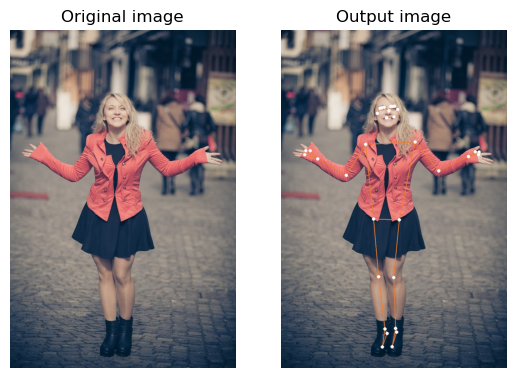

In [5]:
img_path = 'media/sample.jpg'
image = cv2.imread(img_path)
detectPose(image,pose_img,draw=True,display=True)

In [6]:
def checkHandsJoined(image,results,draw=False,display=False):
    height,width,_ =image.shape
    output_image = image.copy()
    left_wrist_landmark = (results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_WRIST].x * width,
                           results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_WRIST].y * height)
    right_wrist_landmark = (results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_WRIST].x * width,
                           results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_WRIST].y * height)
    euclidean_distance = int(hypot(left_wrist_landmark[0]-right_wrist_landmark[0],
                                   left_wrist_landmark[1]-right_wrist_landmark[1]))
    if euclidean_distance <130:
        hand_status = 'Hands Joined'
        color = (0,255,0)
    else:
        hand_status = 'Hands not Joined'
        color = (0,0,255)
    if draw:
        cv2.putText(output_image,hand_status,(10,30),cv2.FONT_HERSHEY_PLAIN,2,color,3)
        cv2.putText(output_image,f'Distance: {euclidean_distance}',(10,70),cv2.FONT_HERSHEY_PLAIN,2,color,3)
    if display:
        plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis("off")
    else:
         return output_image,hand_status

In [7]:
camera_video = cv2.VideoCapture(0)
cv2.namedWindow("Hands Joined?",cv2.WINDOW_NORMAL)
while camera_video.isOpened():
    ok,frame = camera_video.read()
    if not ok:
        break
    frame = cv2.flip(frame,1)
    frame_height,frame_width,_ = frame.shape
    frame,results = detectPose(frame,pose_video,draw=True)
    if results.pose_landmarks:
        frame,_ =checkHandsJoined(frame,results,draw=True)
    cv2.imshow('Hands Joined?',frame)
    k=cv2.waitKey(1) & 0xFF
    if(k==27):
        break
camera_video.release()
cv2.destroyAllWindows()

C:\Users\Dell\anaconda3\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


In [8]:
def checkLeftRight(image,results,draw=False,display=False):
    horizontal_position = None
    height,width,_ = image.shape
    output_image = image.copy()
    left_x = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER].x *width)
    right_x = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER].x *width)
    if(right_x<=width//2 and left_x<=width//2):
        horizontal_position = 'left'
    elif(right_x<=width//2 and left_x>=width//2):
        horizontal_position = 'center'
    elif(right_x>=width//2 and left_x>=width//2):
        horizontal_position = 'right'
    cv2.putText(output_image,horizontal_position,(5,height-10),cv2.FONT_HERSHEY_PLAIN,2,(255,255,255),3)
    if draw:
        cv2.line(output_image,(width//2,0),(width//2,height),(255,255,255),2)
    if display:
        cv2.imshow(output_image[:,:,::-1]);plt.title('Output image');plt.axis('off')
    else:
        return output_image,horizontal_position

In [9]:
camera_video = cv2.VideoCapture(0)
cv2.namedWindow("Horizontal Movements",cv2.WINDOW_NORMAL)
while camera_video.isOpened():
    ok,frame = camera_video.read()
    if not ok:
        break
    frame = cv2.flip(frame,1)
    frame_height,frame_width,_ = frame.shape
    frame,results = detectPose(frame,pose_video,draw=True)
    if results.pose_landmarks:
        frame,_ =checkLeftRight(frame,results,draw=True)
    cv2.imshow('Horizontal Movements',frame)
    k=cv2.waitKey(1) & 0xFF
    if(k==27):
        break
camera_video.release()
cv2.destroyAllWindows()

In [10]:
def checkJumpCrouch(image,results,MID_Y=250,draw=False,display=False):
    posture = None
    height,width,_ = image.shape
    output_image = image.copy()
    left_y = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER].y *height)
    right_y = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER].y *height)
    actual_mid_y=abs(right_y+left_y)//2
    lower_bound =MID_Y-15
    upper_bound =MID_Y+100
    if(actual_mid_y < lower_bound):
        posture = 'Jumping'
    elif(actual_mid_y > upper_bound):
        posture = 'Crouching'
    else:
        posture='Standing'
    cv2.putText(output_image,posture,(5,height-50),cv2.FONT_HERSHEY_PLAIN,2,(255,255,255),3)
    if draw:
        cv2.line(output_image,(0,MID_Y),(width,MID_Y),(255,255,255),2)
    if display:
        cv2.imshow(output_image[:,:,::-1]);plt.title('Output image');plt.axis('off')
    else:
        return output_image,posture

In [11]:
camera_video = cv2.VideoCapture(0)
cv2.namedWindow("Vertical Movements",cv2.WINDOW_NORMAL)
while camera_video.isOpened():
    ok,frame = camera_video.read()
    if not ok:
        break
    frame = cv2.flip(frame,1)
    frame_height,frame_width,_ = frame.shape
    frame,results = detectPose(frame,pose_video,draw=True)
    if results.pose_landmarks:
        frame,_ = checkJumpCrouch(frame,results,draw=True)
    cv2.imshow('Vertical Movements',frame)
    k=cv2.waitKey(1) & 0xFF
    if(k==27):
        break
camera_video.release()
cv2.destroyAllWindows()

In [12]:
pyautogui.press(keys='up')

In [13]:
pyautogui.keyDown(key='shift')
pyautogui.press(keys='enter',presses=1)
pyautogui.keyUp(key='Shift')

In [14]:
print('hello')

hello


In [15]:
camera_video = cv2.VideoCapture(0)
cv2.namedWindow('subway surfers with Pose Detection',cv2.WINDOW_NORMAL)
time1=0
game_Started =False
x_pos_index = 1
y_pos_index = 1
MID_Y = None
counter = 0
num_of_frames = 10
while camera_video.isOpened():
    ok,frame = camera_video.read()
    if not ok:
        continue
    frame = cv2.flip(frame,1)
    frame_height,frame_width,_ = frame.shape
    frame,results = detectPose(frame,pose_video,draw=game_Started)
    if results.pose_landmarks:
        if game_Started:
            frame,horizontal_position = checkLeftRight(frame,results,draw=True)
            if(horizontal_position=='left' and x_pos_index!=0) or (horizontal_position=='center' and x_pos_index==2):
                pyautogui.press('left')
                x_pos_index -= 1
            elif(horizontal_position=='right' and x_pos_index!=2) or (horizontal_position=='center' and x_pos_index==0):
                pyautogui.press('right')
                x_pos_index += 1
        else:
            cv2.putText(frame,"Join your hands to start the game: ",(5,frame_height-10),cv2.FONT_HERSHEY_PLAIN,2,(0,255,0),3)
        if checkHandsJoined(frame,results)[1]=='Hands Joined' :
            counter += 1
            if counter == num_of_frames:
                if not(game_Started):
                    game_Started = True
                    left_y = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER].y * frame_height)
                    right_y = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER].y * frame_height)
                    MID_Y = abs(right_y + left_y) // 2
                    pyautogui.click(x=200,y=200,button='left')
                    #pyautogui.press('space')
                
                else:   
                    pyautogui.press('space')
                    counter = 0;
        else:
            counter=0
        if MID_Y:
            frame,posture = checkJumpCrouch(frame,results,MID_Y,draw=True)
            if posture == 'Jumping' and y_pos_index == 1:
                #cv2.putText(frame,'Working...',(50,50),cv2.FONT_HERSHEY_PLAIN,2,(0,255,0),3)
                pyautogui.press('up')
                y_p os_index += 1
            elif posture == 'Crouching' and y_pos_index == 1:
                pyautogui.press('down')
                y_pos_index -= 1
            elif posture == 'Standing' and y_pos_index != 1:
                y_pos_index = 1
    else:
        counter = 0
    time2 = time()
    if(time2 - time1) > 0 :
        frames_per_second = 1.0 / (time2 - time1)
        cv2.putText(frame,'FPS: {}'.format(int(frames_per_second)),(10,30),cv2.FONT_HERSHEY_PLAIN,2,(0,255,0),3)
        time1 = time2
        cv2.imshow('Subway Surfers with Pose Detection',frame)
        k=cv2.waitKey(1) & 0xFF
        if(k == 27):
            break
camera_video.release()
cv2.destroyAllWindows()